# JUDUL FP

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import operator

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from statistics import mean

In [2]:
#fungsi buat dapetin jarak eucledian
#data1 = data pertama
#data2 = data pembanding
#length = jumlah variabel yang dibandingkan
def eucledianDistance(data1, data2, length):
    distance = 0
    for x in range(length):
        distance += pow((float(data1[x]) - float(data2[x])), 2)
        # print(str(data1) + "-" + str(data2) + ": " + str(distance))
    return math.sqrt(distance)

In [3]:
#fungsi untuk mendapatkan tetangga terdekat
#trainingset = data training / ground truth
#testdata = data testing / data yang diuji
#k = tetangga
def getNeighbors(trainingSet, testData, testClass, k):
    #array distance untuk nyimpan jarak, nanti akan disort yang tedekat
    # print(len(testData))
    distance = []
    length = len(testData) - 1
    for x in range(len(trainingSet)):
        dist = eucledianDistance(testData, trainingSet[x], length)
        distance.append((trainingSet[x], testClass[x], dist))
        # print((trainingSet[x], dist))
    distance.sort(key=operator.itemgetter(2))
    # print(distance)
    neighbors = []
    for x in range(k):
        #habis disort, data tetangga terdekat disimpan di array neighbors
        neighbors.append(distance[x][0:2])
    # print(neighbors)
    return neighbors

In [4]:
#fungsi getResponse buat nyari datatest masuk kelas mana / voting kelasnya
def getResponse(neighbors):
    #classvote disiapin buat penampung proses voting kelas
    classVote = {}
    # print(neighbors)
    for x in range(len(neighbors)):
        response = neighbors[x][-1]
        # print(response)
        if response in classVote:
            classVote[response] += 1
        else:
            classVote[response] = 1
    # print(classVote)
    # sortedVotes buat milih vote kelas terbanyak
    sortedVotes = sorted(classVote.items(), key=operator.itemgetter(1), reverse=True)
    # print(sortedVotes[0][0])
    return sortedVotes[0][0]

In [5]:
#fungsi getAccuracy untuk mendapatkan nilai akurasi
#testData adalah kelas dari data yang dicek
#prediction adalah prediksi kelas dari data yang dicek
def getAccuracy(testData, predictions):
    correct = 0
#     print(len(testData))
#     print(len(predictions))
    for x in range(len(testData)):
        #jika prediksi benar, maka nilai correct bertambah +1
        if testData[x] == predictions[x]:
            correct += 1
    #mengembalikan nilai return persentase
#    print(correct)
    return (correct/float(len(testData))) * 100.0

In [6]:
#Load dataset
path = "dataset/iris.data"
# path = "dataset/transfusion.data"
# path = "dataset/bupa.data"

In [7]:
namesIris = [
    'sepal-length',
    'sepal-width',
    'petal-width',
    'petal-length',
    'class'
]

nameTransfusion = [
    'Recency',
    'Frequency',
    'Monetary',
    'Time',
    'Yes/No Donate'
]

nameBupa = [
    'mcv',
    'alkphos',
    'sgpt',
    'sgot',
    'gammagt',
    'drinks',
    'selector'
]

## Iris Dataset

In [8]:
dataset = pd.read_csv(path, header=None)
print(len(dataset))

150


In [9]:
##Dataset preprocessing
#membagi jadi 2, X untuk nilai numerik, Y untuk nama kelas
X = dataset.iloc[:, :-1].values
Y = dataset.iloc[:, -1].values

In [10]:
#split dataset 90% train-10% test
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [11]:
prediction = []
for i in range(len(x_test)):
    #mendapatkan tetangga terdekat
    neighbors = getNeighbors(x_train, x_test[i], y_train, 3)
    #mendapatkan kelas berdasarkan tetangga terdekat
    result = getResponse(neighbors)
    #memasukkan nilai kelas ke array prediction
    prediction.append(result)
#     print('> predicted=' + repr(result) + ', actual=' + repr(y_test[i]))
    neighbors.clear()
#menghitung akurasi dengan mengecek antara akurasi dengan nama kelas yang sebenarnya
accuracy = getAccuracy(y_test, prediction)
prediction.clear()
# print(y_test)
# print(prediction)
print('Non-KFold Accuracy: ' + repr(accuracy) + "%")
    # print(train)
    # print(test)
    # print(KF_xtrain)
    # for j in range(len(test)):
        # KFold_neighbors = getNeighbors()

Non-KFold Accuracy: 86.66666666666667%


In [15]:
#5 Fold
# k from 1 to 10

knn_5fold_iris = []
for k in range(1, 11):
    fold = 1
    KF_xtrain = []
    KF_xtest = []
    KF_ytrain = []
    KF_ytest = []
    knn_5fold_result = []
    kfold = KFold(n_splits=5, shuffle=True, random_state=True)
    for train, test in kfold.split(X, Y):
        # print('train: %s, test: %s' % (X[train], X[test]))
        KF_xtrain.append(X[train])
        KF_xtest.append(X[test])
        KF_ytrain.append(Y[train])
        KF_ytest.append(Y[test])
        for j in range(len(KF_xtest[0])):
            neighbors = getNeighbors(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], k)
            result = getResponse(neighbors)
            prediction.append(result)
            neighbors.clear()
        accuracy = getAccuracy(KF_ytest[0], prediction)
        knn_5fold_result.append(accuracy)
        prediction.clear()
        # print(y_test)
        # print(prediction)
        fold += 1
        KF_xtest.clear()
        KF_xtrain.clear()
        KF_ytest.clear()
        KF_ytrain.clear()
    print('K = ' + str(k) + ' Accuracy: ' + str(mean(knn_5fold_result)) + "%")
    knn_5fold_iris.append(mean(knn_5fold_result))


K = 1 Accuracy: 92.0%
K = 2 Accuracy: 92.0%
K = 3 Accuracy: 94.66666666666667%
K = 4 Accuracy: 94.0%
K = 5 Accuracy: 94.0%
K = 6 Accuracy: 94.66666666666667%
K = 7 Accuracy: 94.0%
K = 8 Accuracy: 95.33333333333334%
K = 9 Accuracy: 95.33333333333334%
K = 10 Accuracy: 94.66666666666667%


In [16]:
#10 Fold

knn_10fold_iris = []
for k in range(1, 11):
    fold = 1
    KF_xtrain = []
    KF_xtest = []
    KF_ytrain = []
    KF_ytest = []
    knn_10fold_result = []
    kfold = KFold(n_splits=10, shuffle=True, random_state=True)
    for train, test in kfold.split(X, Y):
        # print('train: %s, test: %s' % (X[train], X[test]))
        KF_xtrain.append(X[train])
        KF_xtest.append(X[test])
        KF_ytrain.append(Y[train])
        KF_ytest.append(Y[test])
        for j in range(len(KF_xtest[0])):
            neighbors = getNeighbors(KF_xtrain[0], KF_xtest[0][j], KF_ytrain[0], k)
            result = getResponse(neighbors)
            prediction.append(result)
            neighbors.clear()
        accuracy = getAccuracy(KF_ytest[0], prediction)
        knn_10fold_result.append(accuracy)
        prediction.clear()
        # print(y_test)
        # print(prediction)
        fold += 1
        KF_xtest.clear()
        KF_xtrain.clear()
        KF_ytest.clear()
        KF_ytrain.clear()
    print('K = ' + str(k) + ' Accuracy: ' + str(mean(knn_10fold_result)) + "%")
    knn_10fold_iris.append(mean(knn_10fold_result))

K = 1 Accuracy: 92.0%
K = 2 Accuracy: 92.0%
K = 3 Accuracy: 94.66666666666666%
K = 4 Accuracy: 93.33333333333333%
K = 5 Accuracy: 94.66666666666667%
K = 6 Accuracy: 94.0%
K = 7 Accuracy: 93.33333333333333%
K = 8 Accuracy: 94.66666666666666%
K = 9 Accuracy: 94.66666666666666%
K = 10 Accuracy: 94.66666666666666%


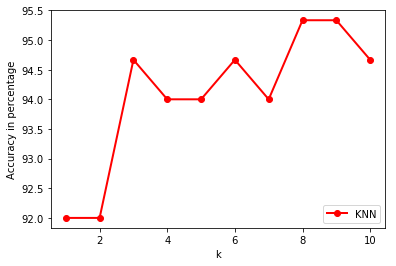

In [17]:
plt.plot([1,2,3,4,5,6,7,8,9,10],knn_5fold_iris,'-ro', label="KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()

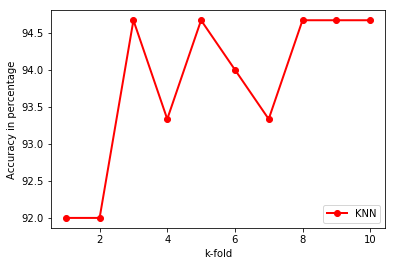

In [18]:
plt.plot([1,2,3,4,5,6,7,8,9,10],knn_10fold_iris,'-ro', label="KNN", linewidth=2.0)
plt.legend(loc='lower right')
plt.xlabel('k nearest neighbour')
plt.ylabel('Accuracy in percentage')
plt.show()